In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import official.nlp.modeling.layers as nlp_layers

import warnings
warnings.filterwarnings('ignore')

from edward_utils import RandomFeatureGaussianProcess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from ucimlrepo import fetch_ucirepo 


2024-06-14 10:47:05.443489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# fetch dataset 
magic_gamma_telescope = fetch_ucirepo(id=159) 

# data (as pandas dataframes) 
X = magic_gamma_telescope.data.features 
y = magic_gamma_telescope.data.targets 
  
# metadata 
print(magic_gamma_telescope.metadata) 
  
# variable information 
print(magic_gamma_telescope.variables)

{'uci_id': 159, 'name': 'MAGIC Gamma Telescope', 'repository_url': 'https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope', 'data_url': 'https://archive.ics.uci.edu/static/public/159/data.csv', 'abstract': 'Data are MC generated to simulate registration of high energy gamma particles in an atmospheric Cherenkov telescope', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 19020, 'num_features': 10, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2004, 'last_updated': 'Tue Dec 19 2023', 'dataset_doi': '10.24432/C52C8B', 'creators': ['R. Bock'], 'intro_paper': None, 'additional_info': {'summary': "The data are MC generated (see below) to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamm

In [3]:
tf.random.set_seed(14)
tf.keras.utils.set_random_seed(14)
tf.config.experimental.enable_op_determinism()

In [4]:
df0 = pd.concat([X, y], axis=1)

In [5]:
column_names = list(df0.columns)
column_names

['fLength',
 'fWidth',
 'fSize',
 'fConc',
 'fConc1',
 'fAsym',
 'fM3Long',
 'fM3Trans',
 'fAlpha',
 'fDist',
 'class']

In [6]:
df0.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [7]:
class_mapping = {'g':0, 'h':1}
df0['class'] = df0['class'].map(class_mapping)

In [8]:
data0 = df0.values
random_state = 2
train0, test0, _, _ = train_test_split(data0, data0, test_size=0.2, random_state = random_state)

In [9]:
X_train0 = train0[:,:10]
y_train0 = train0[:,-1]

X_test0 = test0[:,:10]
y_test0 = test0[:,-1]

In [10]:
print(X_train0, y_train0)

[[ 24.1542  17.677    2.5629 ...  -8.0966  56.148   73.9966]
 [ 28.7755  10.9466   2.5198 ...  -7.5287   5.5984  88.8504]
 [ 24.6743  15.1377   2.5496 ...  -2.5673   0.373  154.539 ]
 ...
 [ 62.2195  24.2531   3.2907 ... -11.0521   1.5585 247.374 ]
 [ 97.1493  34.31     3.8354 ... -23.8441   1.94   334.315 ]
 [ 95.1033  34.0783   4.0022 ...  26.214    0.851  253.539 ]] [0. 0. 0. ... 0. 0. 0.]


In [11]:
scaler = StandardScaler()
scaler.fit(X_train0)
X_train0 = scaler.transform(X_train0)
X_test0 = scaler.transform(X_test0)

In [12]:
print(X_train0, y_train0)

[[-0.68825917 -0.24406502 -0.55302799 ... -0.40248923  1.10070537
  -1.60048348]
 [-0.5789348  -0.61377741 -0.64434728 ... -0.37507292 -0.83881371
  -1.40225879]
 [-0.67595536 -0.38355312 -0.58120772 ... -0.13555314 -1.03930517
  -0.52564121]
 ...
 [ 0.21223749  0.1171714   0.98901787 ... -0.54517088 -0.99381915
   0.71324641]
 [ 1.03855879  0.66961413  2.14311567 ... -1.16272582 -0.97918152
   1.87347832]
 [ 0.99015733  0.65688646  2.49652767 ...  1.25391168 -1.02096496
   0.79551864]] [0. 0. 0. ... 0. 0. 0.]


In [13]:
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)

  def call(self, inputs):
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)

    # Computes the ResNet hidden representations.
    for i in range(self.num_layers):
        resid = self.dense_layers[i](hidden)
        resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
        hidden += resid

    return self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(num_classes, **self.classifier_kwargs)

In [14]:
class DeepResNetSNGP(DeepResNet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(dense_layer, norm_multiplier=self.spec_norm_bound)
#     return dense_layer

  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
#     return nlp_layers.RandomFeatureGaussianProcess(num_classes, gp_cov_momentum=-1, **self.classifier_kwargs)
    return RandomFeatureGaussianProcess(num_classes, gp_cov_momentum=-1, **self.classifier_kwargs)

  def call(self, inputs, training=False, return_covmat=False, return_rff=False):
    # Gets logits and a covariance matrix from the GP layer.
    logits, covmat, rff = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat and return_rff:
        return logits, covmat, rff
    elif not training and return_covmat:
        return logits, covmat
    return logits

In [15]:
resnet_config = dict(num_classes=2, num_layers=3, num_hidden=32, return_random_features=True)

In [16]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):

    def on_epoch_begin(self, epoch, logs=None):
        """Resets covariance matrix at the beginning of the epoch."""
        if epoch > 0:
            self.model.classifier.reset_covariance_matrix()

In [17]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
    def fit(self, *args, **kwargs):
        """Adds ResetCovarianceCallback to model callbacks."""
        kwargs["callbacks"] = list(kwargs.get("callbacks", []))
        kwargs["callbacks"].append(ResetCovarianceCallback())

        return super().fit(*args, **kwargs)

In [18]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy(),
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)

2024-06-14 10:48:35.537452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
fit_config = dict(batch_size=128, epochs=200)

In [20]:
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model.compile(**train_config)
sngp_model.fit(X_train0, y_train0, **fit_config)

Epoch 1/200
119/119 [==============================] - 4s 7ms/step - loss: 0.6688 - sparse_categorical_accuracy: 0.6133
Epoch 2/200
119/119 [==============================] - 1s 9ms/step - loss: 0.5409 - sparse_categorical_accuracy: 0.7726
Epoch 3/200
119/119 [==============================] - 1s 10ms/step - loss: 0.4359 - sparse_categorical_accuracy: 0.8257
Epoch 4/200
119/119 [==============================] - 1s 8ms/step - loss: 0.4022 - sparse_categorical_accuracy: 0.8381
Epoch 5/200
119/119 [==============================] - 1s 8ms/step - loss: 0.3755 - sparse_categorical_accuracy: 0.8498
Epoch 6/200
119/119 [==============================] - 1s 8ms/step - loss: 0.3655 - sparse_categorical_accuracy: 0.8534
Epoch 7/200
119/119 [==============================] - 1s 8ms/step - loss: 0.3569 - sparse_categorical_accuracy: 0.8550
Epoch 8/200
119/119 [==============================] - 1s 8ms/step - loss: 0.3515 - sparse_categorical_accuracy: 0.8557
Epoch 9/200
119/119 [==================

119/119 [==============================] - 1s 7ms/step - loss: 0.2972 - sparse_categorical_accuracy: 0.8740
Epoch 69/200
119/119 [==============================] - 1s 8ms/step - loss: 0.2945 - sparse_categorical_accuracy: 0.8774
Epoch 70/200
119/119 [==============================] - 1s 8ms/step - loss: 0.2911 - sparse_categorical_accuracy: 0.8801
Epoch 71/200
119/119 [==============================] - 1s 8ms/step - loss: 0.2941 - sparse_categorical_accuracy: 0.8768
Epoch 72/200
119/119 [==============================] - 1s 8ms/step - loss: 0.2895 - sparse_categorical_accuracy: 0.8795
Epoch 73/200
119/119 [==============================] - 1s 7ms/step - loss: 0.2905 - sparse_categorical_accuracy: 0.8797
Epoch 74/200
119/119 [==============================] - 1s 7ms/step - loss: 0.2918 - sparse_categorical_accuracy: 0.8785
Epoch 75/200
119/119 [==============================] - 1s 7ms/step - loss: 0.2930 - sparse_categorical_accuracy: 0.8782
Epoch 76/200
119/119 [=======================

119/119 [==============================] - 1s 11ms/step - loss: 0.2878 - sparse_categorical_accuracy: 0.8792
Epoch 136/200
119/119 [==============================] - 1s 12ms/step - loss: 0.2847 - sparse_categorical_accuracy: 0.8786
Epoch 137/200
119/119 [==============================] - 1s 12ms/step - loss: 0.2868 - sparse_categorical_accuracy: 0.8793
Epoch 138/200
119/119 [==============================] - 1s 11ms/step - loss: 0.2873 - sparse_categorical_accuracy: 0.8802
Epoch 139/200
119/119 [==============================] - 1s 10ms/step - loss: 0.2855 - sparse_categorical_accuracy: 0.8797
Epoch 140/200
119/119 [==============================] - 1s 11ms/step - loss: 0.2845 - sparse_categorical_accuracy: 0.8816
Epoch 141/200
119/119 [==============================] - 1s 11ms/step - loss: 0.2852 - sparse_categorical_accuracy: 0.8805
Epoch 142/200
119/119 [==============================] - 1s 10ms/step - loss: 0.2844 - sparse_categorical_accuracy: 0.8795
Epoch 143/200
119/119 [=======

In [21]:
sngp_model.evaluate(X_test0, y_test0)

119/119 [==============================] - 1s 1ms/step - loss: 0.3209 - sparse_categorical_accuracy: 0.8741


[0.32091575860977173, 0.8740799427032471]

In [22]:
y_test0_pred = sngp_model.predict(X_test0)
accuracy0 = (y_test0_pred.argmax(axis=1) == y_test0).sum().item() / len(y_test0)
print(accuracy0)

119/119 [==============================] - 0s 1ms/step
0.8740799158780231


In [24]:
X_train0_output = sngp_model(X_train0, return_covmat=True, return_rff=True)

In [25]:
print(X_train0_output)

(<tf.Tensor: shape=(15216, 2), dtype=float32, numpy=
array([[ 0.6321973, -0.6496123],
       [ 1.3311152, -1.2807955],
       [ 1.8729224, -1.8506968],
       ...,
       [ 2.405408 , -2.4210577],
       [ 2.8398654, -2.804223 ],
       [ 3.2707665, -3.2502108]], dtype=float32)>, <tf.Tensor: shape=(15216, 15216), dtype=float32, numpy=
array([[-5.7851366e-08,  5.0725703e-08,  3.4354343e-08, ...,
        -5.7901218e-08,  8.6090836e-08,  8.4218755e-08],
       [-5.8160481e-09,  2.2926088e-09,  2.9157206e-08, ...,
        -2.9906062e-08,  1.8397941e-08, -3.0150147e-08],
       [-8.9919013e-08,  8.5868010e-08,  9.8434612e-08, ...,
         5.9553713e-09,  6.9779617e-08,  3.4937784e-08],
       ...,
       [ 1.2643818e-07, -4.6695732e-08, -9.7168140e-08, ...,
        -1.2325222e-07, -3.2033768e-08, -2.6752537e-07],
       [-3.0518322e-08, -1.5280648e-08,  2.8145109e-08, ...,
        -2.7395899e-08,  4.4146873e-09, -1.6973075e-08],
       [-4.3297860e-08, -8.3275893e-09, -9.2768232e-08, ...,


In [26]:
rff0 = X_train0_output[-1]

In [27]:
def plot_xy(x_values, label, title):
    df = pd.DataFrame(x_values, columns=['x', 'y'])
    df['label'] = label
    sns.scatterplot(x="x", y="y", hue="label", data=df)
    plt.title(title)
    plt.show()

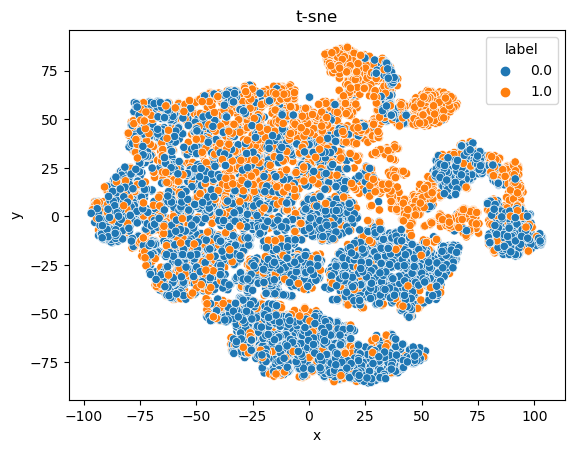

In [28]:
tsne0 = TSNE(n_components=2)
X_train0_tsne = tsne0.fit_transform(X_train0)
plot_xy(X_train0_tsne, y_train0, "t-sne")

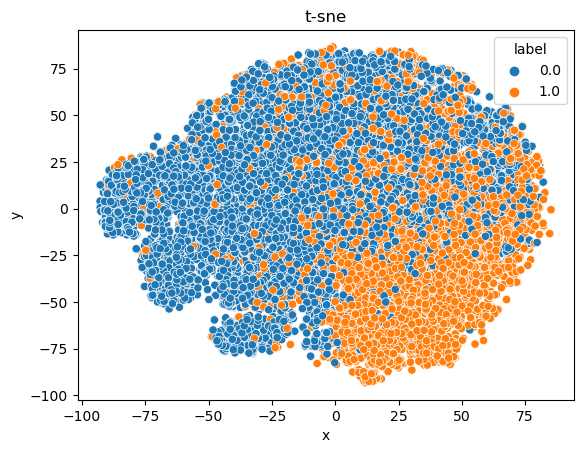

In [29]:
rff0_tsne = tsne0.fit_transform(rff0)
plot_xy(rff0_tsne, y_train0, "t-sne")

In [30]:
# def show_elbow_score(data_values):
#     sse = {}
#     kmax = 10
    
#     for k in range(1, 10):
#         kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data_values)
#         sse[k] = kmeans.inertia_  # Inertia: Sum of distances of samples to their closest cluster center
#     sns.lineplot(x=list(sse.keys()), y=list(sse.values()))
#     plt.title('Elbow Method')
#     plt.xlabel("k : Number of cluster")
#     plt.ylabel("Sum of Squared Error")
#     plt.grid()
#     plt.show

In [31]:
# show_elbow_score(rff0)

In [32]:
# def show_silhouette_score(data_values):
#     sil = []
#     kmax = 10
    
#     for k in range(2, kmax + 1):
#         kmeans = KMeans(n_clusters=k).fit(data_values)
#         labels = kmeans.labels_
#         sil.append(silhouette_score(data_values, labels, metric='euclidean'))
#     sns.lineplot(x=range(2, kmax + 1), y=sil)
#     plt.title('Silhouette Score Method')
#     plt.xlabel("k : Number of cluster")
#     plt.ylabel("Silhouette Score")
#     plt.grid()

#     plt.show()

In [33]:
# show_silhouette_score(rff)

In [34]:
# model=KMeans(n_clusters=4)
# model.fit(rff)
# y_pre= model.predict(rff)

# plot_xy(rff_tsne, y_pre, "k-means' result")

In [35]:
# counts = pd.value_counts(y_pre,sort=True)

In [36]:
# counts

In [37]:
sngp_logits0 = X_train0_output[0]
sngp_logits0

<tf.Tensor: shape=(15216, 2), dtype=float32, numpy=
array([[ 0.6321973, -0.6496123],
       [ 1.3311152, -1.2807955],
       [ 1.8729224, -1.8506968],
       ...,
       [ 2.405408 , -2.4210577],
       [ 2.8398654, -2.804223 ],
       [ 3.2707665, -3.2502108]], dtype=float32)>

In [38]:
sngp_covmat0 = X_train0_output[1]
sngp_covmat0

<tf.Tensor: shape=(15216, 15216), dtype=float32, numpy=
array([[-5.7851366e-08,  5.0725703e-08,  3.4354343e-08, ...,
        -5.7901218e-08,  8.6090836e-08,  8.4218755e-08],
       [-5.8160481e-09,  2.2926088e-09,  2.9157206e-08, ...,
        -2.9906062e-08,  1.8397941e-08, -3.0150147e-08],
       [-8.9919013e-08,  8.5868010e-08,  9.8434612e-08, ...,
         5.9553713e-09,  6.9779617e-08,  3.4937784e-08],
       ...,
       [ 1.2643818e-07, -4.6695732e-08, -9.7168140e-08, ...,
        -1.2325222e-07, -3.2033768e-08, -2.6752537e-07],
       [-3.0518322e-08, -1.5280648e-08,  2.8145109e-08, ...,
        -2.7395899e-08,  4.4146873e-09, -1.6973075e-08],
       [-4.3297860e-08, -8.3275893e-09, -9.2768232e-08, ...,
        -4.2010925e-08,  2.6341695e-08, -7.1513796e-08]], dtype=float32)>

In [39]:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
    # Computes uncertainty-adjusted logits using the built-in method.
    logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)

    return tf.nn.softmax(logits_adjusted, axis=-1)[:, 0]

In [40]:
sngp_probs0 = compute_posterior_mean_probability(sngp_logits0, sngp_covmat0)
sngp_probs0

<tf.Tensor: shape=(15216,), dtype=float32, numpy=
array([0.78275764, 0.93162423, 0.97642285, ..., 0.9920489 , 0.9964741 ,
       0.9985299 ], dtype=float32)>

In [41]:
# def plot_xy_uncertainty(x_values, score, title):
#     df = pd.DataFrame(x_values, columns=['x', 'y'])
#     df['score'] = score
#     plt.figure(figsize=(8, 6))
#     plt.scatter(x='x', y='y', c='score', cmap='viridis')

#     plt.colorbar(label='score')
#     plt.grid(True)
#     plt.show()

In [42]:
# def plot_xy_uncertainty(x_values, score, title):
#     df = pd.DataFrame(x_values, columns=['x', 'y'])
#     df['score'] = score
#     plt.figure(figsize=(8, 6))
#     sns.scatterplot(x='x', y='y', data=df, hue='score', legend=False, palette="YlGnBu", alpha=0.5)

#     plt.colorbar(label='score')
#     plt.show()

In [43]:
# def plot_ambiguity_score(pred_probs):
    
#     # Compute ambiguity score.
#     ambiguity_score = 1 - abs(pred_probs - (1. - pred_probs))

#     plot_xy_uncertainty(rff_tsne, ambiguity_score, "Ambiguity score, SNGP")


In [44]:
# plot_ambiguity_score(sngp_probs)

In [45]:
ambiguity_score0 = 1 - abs(sngp_probs0 - (1. - sngp_probs0))
ambiguity_score0

<tf.Tensor: shape=(15216,), dtype=float32, numpy=
array([0.43448472, 0.13675153, 0.04715431, ..., 0.01590216, 0.00705183,
       0.00294018], dtype=float32)>

In [46]:
df1 = pd.DataFrame(rff0_tsne, columns=['x', 'y'])
df1['score'] = ambiguity_score0
df1

,x,y,score
0,23.946629,0.191432,0.434485
1,-28.107256,49.033234,0.136752
2,-18.422056,31.109039,0.047154
3,10.614422,-20.392460,0.298945
4,-46.020699,-16.887629,0.010479
...,...,...,...
15211,-17.234264,-33.166370,0.062555
15212,11.613563,31.598385,0.242185
15213,-61.122639,-34.116398,0.015902
15214,-72.054367,-46.348923,0.007052


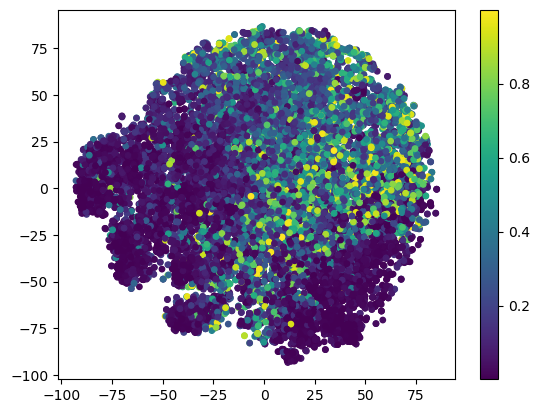

In [47]:
plt.scatter(x=df1['x'], y=df1['y'], s=15, c=df1['score'], cmap='viridis')
plt.colorbar()
plt.show()

In [48]:
count_as = 0
for i in ambiguity_score0:
    if i >= 0.4:
        count_as +=1
count_as

3106

In [49]:
df_score0 = pd.DataFrame(ambiguity_score0, columns=['score'])
df_X_train0 = pd.DataFrame(X_train0, columns=['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long',
                                           'fM3Trans', 'fAlpha', 'fDist'])
df_y_train0 = pd.DataFrame(y_train0, columns=['class'])

In [50]:
df_train0 = pd.concat([df_X_train0, df_y_train0, df_score0], axis=1)
df_train0

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,score
0,-0.688259,-0.244065,-0.553028,0.133466,0.322409,0.449936,-0.458654,-0.402489,1.100705,-1.600483,0.0,0.434485
1,-0.578935,-0.613777,-0.644347,0.364315,0.258084,0.240320,0.065335,-0.375073,-0.838814,-1.402259,0.0,0.136752
2,-0.675955,-0.383553,-0.581208,-0.044321,-0.245649,0.005502,-0.526951,-0.135553,-1.039305,-0.525641,0.0,0.047154
3,-0.179098,0.902992,1.414045,-1.237953,-1.242244,-0.145720,0.524273,-1.100483,1.324740,-0.794397,0.0,0.298945
4,-0.321466,-0.066559,0.404235,-0.373636,-0.425943,0.456657,0.599169,-0.635105,-0.909301,-0.449054,0.0,0.010479
...,...,...,...,...,...,...,...,...,...,...,...,...
15211,-0.109284,-0.515318,-0.159571,0.026794,-0.126964,-1.270105,0.502359,0.268199,-0.945839,0.764612,0.0,0.062555
15212,-0.680093,-0.292608,-0.898812,0.097909,-0.049955,0.183561,-0.440195,0.629323,0.214758,-1.004515,1.0,0.242185
15213,0.212237,0.117171,0.989018,-1.112135,-1.047455,0.239180,0.646386,-0.545171,-0.993819,0.713246,0.0,0.015902
15214,1.038559,0.669614,2.143116,-1.287734,-1.229560,0.897013,1.405670,-1.162726,-0.979182,1.873478,0.0,0.007052


In [51]:
# Drop the training data whose ambiguity score bigger than or equal to 0.4
df_drop_train0=df_train0[(df_train0['score']<0.4)]
df_drop_train0

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,score
1,-0.578935,-0.613777,-0.644347,0.364315,0.258084,0.240320,0.065335,-0.375073,-0.838814,-1.402259,0.0,0.136752
2,-0.675955,-0.383553,-0.581208,-0.044321,-0.245649,0.005502,-0.526951,-0.135553,-1.039305,-0.525641,0.0,0.047154
3,-0.179098,0.902992,1.414045,-1.237953,-1.242244,-0.145720,0.524273,-1.100483,1.324740,-0.794397,0.0,0.298945
4,-0.321466,-0.066559,0.404235,-0.373636,-0.425943,0.456657,0.599169,-0.635105,-0.909301,-0.449054,0.0,0.010479
5,1.130742,0.172037,0.532421,-0.397706,-0.447686,-0.681546,0.546881,-1.139321,-1.037513,1.898447,0.0,0.161835
...,...,...,...,...,...,...,...,...,...,...,...,...
15211,-0.109284,-0.515318,-0.159571,0.026794,-0.126964,-1.270105,0.502359,0.268199,-0.945839,0.764612,0.0,0.062555
15212,-0.680093,-0.292608,-0.898812,0.097909,-0.049955,0.183561,-0.440195,0.629323,0.214758,-1.004515,1.0,0.242185
15213,0.212237,0.117171,0.989018,-1.112135,-1.047455,0.239180,0.646386,-0.545171,-0.993819,0.713246,0.0,0.015902
15214,1.038559,0.669614,2.143116,-1.287734,-1.229560,0.897013,1.405670,-1.162726,-0.979182,1.873478,0.0,0.007052


In [52]:
# data_drop_train0 = df_drop_train0.values
# X_train1 = data_drop_train0[:,:10]
# y_train1 = data_drop_train0[:,-2]

In [53]:
# print(X_train1, y_train1)

In [54]:
# X_test0_output = sngp_model(X_test0, return_covmat=True, return_rff=True)
# rff0_test = X_test0_output[-1]
# sngp_logits_test0 = X_test0_output[0]
# sngp_covmat_test0 = X_test0_output[1]
# sngp_probs_test0 = compute_posterior_mean_probability(sngp_logits_test0, sngp_covmat_test0)
# ambiguity_score_test0 = 1 - abs(sngp_probs_test0 - (1. - sngp_probs_test0))

In [55]:
# df_score_test0  = pd.DataFrame(ambiguity_score_test0, columns=['score'])
# df_X_test0 = pd.DataFrame(X_test0, columns=['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long',
#                                            'fM3Trans', 'fAlpha', 'fDist'])
# df_y_test0 = pd.DataFrame(y_test0, columns=['class'])

In [56]:
# df_test0 = pd.concat([df_X_test0, df_y_test0, df_score_test0], axis=1)
# df_test0

In [57]:
# df_drop_test0=df_test0[(df_test0['score']<0.4)]
# df_drop_test0

In [58]:
# data_drop_test0 = df_drop_test0.values
# X_test1 = data_drop_test0[:,:10]
# y_test1 = data_drop_test0[:,-2]

In [59]:
# sngp_model_drop0 = DeepResNetSNGPWithCovReset(**resnet_config)
# sngp_model_drop0.build((None, 10))
# sngp_model_drop0.summary()
# sngp_model_drop0.compile(**train_config)
# sngp_model_drop0.fit(X_train1, y_train1, **fit_config)

In [60]:
# y_test1_pred = sngp_model_drop0.predict(X_test1)
# accuracy1 = (y_test1_pred.argmax(axis=1) == y_test1).sum().item() / len(y_test1)
# print(accuracy1)

In [61]:
# y_test0_pred = sngp_model_drop.predict(X_test)
# accuracy_drop0 = (y_test0_pred.argmax(axis=1) == y_test).sum().item() / len(y_test)
# print(accuracy_drop0)

In [62]:
bayes_factor_train = sngp_probs0/(1-sngp_probs0)

In [63]:
# df1 = pd.DataFrame(rff_tsne, columns=['x', 'y'])
# df1['factor'] = bayes_factor_train
# df1

In [64]:
# df_ = df1.sort_values(["factor"],  ascending=True) 
# print(df_)

In [65]:
# df_.to_excel('Bayse Factor.xlsx', index=True)

In [66]:
df_train0['factor'] = bayes_factor_train

In [67]:
df_drop0=df_train0[(df_train0['score']>=0.4)]
df_drop0

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,score,factor
0,-0.688259,-0.244065,-0.553028,0.133466,0.322409,0.449936,-0.458654,-0.402489,1.100705,-1.600483,0.0,0.434485,3.603154
10,-0.510151,-0.673285,-1.047762,0.275695,0.027961,0.675480,0.291526,0.442854,1.472958,-1.580024,0.0,0.909209,0.833531
17,-0.294838,-0.153384,-0.413189,-0.384577,-0.338061,0.735412,0.274414,0.773187,0.756619,-0.629452,0.0,0.450673,3.437809
23,-0.779654,-0.649785,-0.852411,1.358280,1.091599,-0.058650,0.139462,-0.534116,-0.035352,-0.157078,1.0,0.443321,3.511399
31,-0.542721,-0.602725,-0.791814,0.692537,0.994658,-0.173876,-0.479494,-0.364524,1.479097,-0.518742,0.0,0.789897,0.652752
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15196,-0.816842,-0.806395,-1.238664,2.175004,2.362711,0.031947,-0.057505,-0.143311,1.894284,-1.437084,0.0,0.479324,3.172542
15198,-0.565812,-0.501766,-0.606209,0.328758,0.142116,-0.315592,-0.682203,0.214100,1.737893,-0.954885,1.0,0.777691,0.636248
15201,-0.669147,-0.444511,-0.933984,0.090797,0.025243,-0.271237,-0.117602,-0.324551,1.917520,0.517354,1.0,0.916950,0.846637
15206,-0.640014,-0.563471,-0.490948,0.576565,0.267144,-0.305421,-0.397902,0.317489,0.005350,-0.698153,0.0,0.971060,1.059605


In [68]:
# df2 = df_drop0.sort_values(["factor"],  ascending=True)
# print(df2)
# df2.to_excel('Bayes Factor_Drop.xlsx', index=True)

In [69]:
df2_drop=df_drop0[(df_drop0['factor']>2)|(df_drop0['factor']<0.5)]
df2_drop

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,score,factor
0,-0.688259,-0.244065,-0.553028,0.133466,0.322409,0.449936,-0.458654,-0.402489,1.100705,-1.600483,0.0,0.434485,3.603154
17,-0.294838,-0.153384,-0.413189,-0.384577,-0.338061,0.735412,0.274414,0.773187,0.756619,-0.629452,0.0,0.450673,3.437809
23,-0.779654,-0.649785,-0.852411,1.358280,1.091599,-0.058650,0.139462,-0.534116,-0.035352,-0.157078,1.0,0.443321,3.511399
33,-0.457784,-0.846792,-0.520187,0.311800,0.021619,1.153359,0.357471,0.239832,-0.776396,0.771381,1.0,0.618453,0.447653
45,0.025461,-0.052518,0.363343,-0.898244,-0.841794,-0.565070,0.438331,0.445167,-1.039309,-0.205053,0.0,0.426624,3.687968
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15174,-0.885775,-0.564762,-0.788424,1.339680,1.112437,0.041796,-0.105074,-0.270477,0.507672,0.152968,0.0,0.544290,2.674510
15176,-0.565294,-0.570997,-0.940129,-0.121453,-0.303633,-0.084676,-0.610468,0.478111,0.756919,-1.150723,0.0,0.445714,3.487186
15177,-0.704932,-0.320568,-0.558113,0.401514,0.460121,-0.075064,-0.518454,0.489934,2.161986,0.550824,0.0,0.492142,0.326385
15182,-0.574310,-0.799930,-1.126369,1.100079,1.036334,0.284097,-0.355007,-0.275903,0.545166,-1.111355,0.0,0.450587,3.438658


In [70]:
df3 = df_drop_train0

In [71]:
df4 = df3.append(df2_drop, ignore_index=True)
df4

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,score,factor
0,-0.578935,-0.613777,-0.644347,0.364315,0.258084,0.240320,0.065335,-0.375073,-0.838814,-1.402259,0.0,0.136752,NaN
1,-0.675955,-0.383553,-0.581208,-0.044321,-0.245649,0.005502,-0.526951,-0.135553,-1.039305,-0.525641,0.0,0.047154,NaN
2,-0.179098,0.902992,1.414045,-1.237953,-1.242244,-0.145720,0.524273,-1.100483,1.324740,-0.794397,0.0,0.298945,NaN
3,-0.321466,-0.066559,0.404235,-0.373636,-0.425943,0.456657,0.599169,-0.635105,-0.909301,-0.449054,0.0,0.010479,NaN
4,1.130742,0.172037,0.532421,-0.397706,-0.447686,-0.681546,0.546881,-1.139321,-1.037513,1.898447,0.0,0.161835,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13824,-0.885775,-0.564762,-0.788424,1.339680,1.112437,0.041796,-0.105074,-0.270477,0.507672,0.152968,0.0,0.544290,2.674510
13825,-0.565294,-0.570997,-0.940129,-0.121453,-0.303633,-0.084676,-0.610468,0.478111,0.756919,-1.150723,0.0,0.445714,3.487186
13826,-0.704932,-0.320568,-0.558113,0.401514,0.460121,-0.075064,-0.518454,0.489934,2.161986,0.550824,0.0,0.492142,0.326385
13827,-0.574310,-0.799930,-1.126369,1.100079,1.036334,0.284097,-0.355007,-0.275903,0.545166,-1.111355,0.0,0.450587,3.438658


In [72]:
# from sklearn.metrics.pairwise import euclidean_distances
# def kernel(X, y=None, gamma=None):
#     if gamma is None:
#         gamma = 1.0 / X.shape[1]
#     K = euclidean_distances(X, y, squared=True)
#     K *= -gamma
#     np.exp(K, K)  # <==> K = np.exp(K)
#     return K

In [73]:
# W = kernel(X_array, gamma=1.0)
# W

In [74]:
# class LabelPropagation(object):
#     def __init__(self, gamma=20., max_iter=1000, tol=1e-3):
#         self.gamma = gamma
#         self.max_iter = max_iter  # 最大迭代次数
#         self.tol = tol  # 误差容忍度

#     def _get_kernel(self, X, y=None):
#         return kernel(X, y, gamma=self.gamma)

#     def _build_graph(self):
#         affinity_matrix = self._get_kernel(self.X_)  # [n_samples,n_samples]
#         normalizer = affinity_matrix.sum(axis=0, keepdims=True)  # [1, n_samples]
#         affinity_matrix /= normalizer  # [n_samples,n_samples] 归一化得到矩阵T
#         return affinity_matrix
    
#     def fit(self, X, y):
#         self.X_ = X
#         self.graph_matrix = self._build_graph()  # 得到矩阵T，[n_samples,n_samples]
#         classes = np.unique(y)  # 得到分类类别，例如三分类可能是 [-1,0,1,2]，其中-1表示对应样本无标签
#         self.classes_ = (classes[classes != -1])
#         n_samples, n_classes = len(y), len(self.classes_)  # 得到样本数和类别数
#         unlabeled = y == -1  # 得到没有标签的样本对应的索引
#         unlabeled = np.reshape(unlabeled, (-1, 1))
#         self.label_distributions_ = np.zeros((n_samples, n_classes))
        
#         for label in self.classes_:  # 遍历每个类别
#             self.label_distributions_[y == label, self.classes_ == label] = 1
#         y_static = np.copy(self.label_distributions_)
#         l_previous = np.zeros((n_samples, n_classes))
        
#         for self.n_iter_ in range(self.max_iter):
#             if np.abs(self.label_distributions_ - l_previous).sum() < self.tol:
#                 break
#             l_previous = self.label_distributions_
#             self.label_distributions_ = np.matmul(self.graph_matrix, self.label_distributions_)
#             normalizer = np.sum(self.label_distributions_, axis=1, keepdims=True)
#             self.label_distributions_ /= normalizer  # 进行标准化
#             self.label_distributions_ = np.where(unlabeled, self.label_distributions_, y_static)
#         else:
#             logging.warning('max_iter=%d was reached without convergence.' % self.max_iter)
            
#         normalizer = np.sum(self.label_distributions_, axis=1, keepdims=True)
#         normalizer[normalizer == 0] = 1
#         self.label_distributions_ /= normalizer  # 进行标准化
#         self.transduction_ = self.classes_[np.argmax(self.label_distributions_, axis=1)]
        
#         return self
    
#     def predict_proba(self, X):
#         weight_matrices = self._get_kernel(self.X_, X).T  # [X.shape[0],n_train_sample]
#         probabilities = np.matmul(weight_matrices, self.label_distributions_)
#         normalizer = np.sum(probabilities, axis=1, keepdims=True)
#         normalizer[normalizer == 0] = 1 # 平滑处理
#         probabilities /= normalizer
#         return probabilities
    
#     def predict(self, X):
#         probas = self.predict_proba(X)
#         return self.classes_[np.argmax(probas, axis=1)].ravel()

In [75]:
df2_drop1 = df2_drop
df2_drop1['class'] = -1
df2_drop1

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,score,factor
0,-0.688259,-0.244065,-0.553028,0.133466,0.322409,0.449936,-0.458654,-0.402489,1.100705,-1.600483,-1,0.434485,3.603154
17,-0.294838,-0.153384,-0.413189,-0.384577,-0.338061,0.735412,0.274414,0.773187,0.756619,-0.629452,-1,0.450673,3.437809
23,-0.779654,-0.649785,-0.852411,1.358280,1.091599,-0.058650,0.139462,-0.534116,-0.035352,-0.157078,-1,0.443321,3.511399
33,-0.457784,-0.846792,-0.520187,0.311800,0.021619,1.153359,0.357471,0.239832,-0.776396,0.771381,-1,0.618453,0.447653
45,0.025461,-0.052518,0.363343,-0.898244,-0.841794,-0.565070,0.438331,0.445167,-1.039309,-0.205053,-1,0.426624,3.687968
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15174,-0.885775,-0.564762,-0.788424,1.339680,1.112437,0.041796,-0.105074,-0.270477,0.507672,0.152968,-1,0.544290,2.674510
15176,-0.565294,-0.570997,-0.940129,-0.121453,-0.303633,-0.084676,-0.610468,0.478111,0.756919,-1.150723,-1,0.445714,3.487186
15177,-0.704932,-0.320568,-0.558113,0.401514,0.460121,-0.075064,-0.518454,0.489934,2.161986,0.550824,-1,0.492142,0.326385
15182,-0.574310,-0.799930,-1.126369,1.100079,1.036334,0.284097,-0.355007,-0.275903,0.545166,-1.111355,-1,0.450587,3.438658


In [76]:
df5 = df3.append(df2_drop1, ignore_index=True)
df5

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,score,factor
0,-0.578935,-0.613777,-0.644347,0.364315,0.258084,0.240320,0.065335,-0.375073,-0.838814,-1.402259,0.0,0.136752,NaN
1,-0.675955,-0.383553,-0.581208,-0.044321,-0.245649,0.005502,-0.526951,-0.135553,-1.039305,-0.525641,0.0,0.047154,NaN
2,-0.179098,0.902992,1.414045,-1.237953,-1.242244,-0.145720,0.524273,-1.100483,1.324740,-0.794397,0.0,0.298945,NaN
3,-0.321466,-0.066559,0.404235,-0.373636,-0.425943,0.456657,0.599169,-0.635105,-0.909301,-0.449054,0.0,0.010479,NaN
4,1.130742,0.172037,0.532421,-0.397706,-0.447686,-0.681546,0.546881,-1.139321,-1.037513,1.898447,0.0,0.161835,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13824,-0.885775,-0.564762,-0.788424,1.339680,1.112437,0.041796,-0.105074,-0.270477,0.507672,0.152968,-1.0,0.544290,2.674510
13825,-0.565294,-0.570997,-0.940129,-0.121453,-0.303633,-0.084676,-0.610468,0.478111,0.756919,-1.150723,-1.0,0.445714,3.487186
13826,-0.704932,-0.320568,-0.558113,0.401514,0.460121,-0.075064,-0.518454,0.489934,2.161986,0.550824,-1.0,0.492142,0.326385
13827,-0.574310,-0.799930,-1.126369,1.100079,1.036334,0.284097,-0.355007,-0.275903,0.545166,-1.111355,-1.0,0.450587,3.438658


In [77]:
data1 = df4.values
data2 = df5.values
X_array = data1[:,:10]
y_array = data1[:,-3]
y_mixed = data2[:,-3]

In [78]:
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelPropagation

model_lp = LabelPropagation(gamma=20, max_iter=1000)
model_lp.fit(X_array, y_mixed)
y_pred_lp = model_lp.predict(X_array)
print(f"模型的准确率为: {accuracy_score(y_pred_lp, y_array)}")

NameError: name 'model' is not defined

In [79]:
y_pred_lp = model_lp.predict(X_array)
print(f"模型的准确率为: {accuracy_score(y_pred_lp, y_array)}")

模型的准确率为: 0.9500325403138332


In [81]:
df6 = df4
df6['y_pred_lp'] = y_pred_lp
df6

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,score,factor,y_pred_lp
0,-0.578935,-0.613777,-0.644347,0.364315,0.258084,0.240320,0.065335,-0.375073,-0.838814,-1.402259,0.0,0.136752,NaN,0.0
1,-0.675955,-0.383553,-0.581208,-0.044321,-0.245649,0.005502,-0.526951,-0.135553,-1.039305,-0.525641,0.0,0.047154,NaN,0.0
2,-0.179098,0.902992,1.414045,-1.237953,-1.242244,-0.145720,0.524273,-1.100483,1.324740,-0.794397,0.0,0.298945,NaN,0.0
3,-0.321466,-0.066559,0.404235,-0.373636,-0.425943,0.456657,0.599169,-0.635105,-0.909301,-0.449054,0.0,0.010479,NaN,0.0
4,1.130742,0.172037,0.532421,-0.397706,-0.447686,-0.681546,0.546881,-1.139321,-1.037513,1.898447,0.0,0.161835,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13824,-0.885775,-0.564762,-0.788424,1.339680,1.112437,0.041796,-0.105074,-0.270477,0.507672,0.152968,0.0,0.544290,2.674510,0.0
13825,-0.565294,-0.570997,-0.940129,-0.121453,-0.303633,-0.084676,-0.610468,0.478111,0.756919,-1.150723,0.0,0.445714,3.487186,0.0
13826,-0.704932,-0.320568,-0.558113,0.401514,0.460121,-0.075064,-0.518454,0.489934,2.161986,0.550824,0.0,0.492142,0.326385,1.0
13827,-0.574310,-0.799930,-1.126369,1.100079,1.036334,0.284097,-0.355007,-0.275903,0.545166,-1.111355,0.0,0.450587,3.438658,0.0


In [82]:
df7 = df6[-1719:]
df7

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,score,factor,y_pred_lp
12110,-0.688259,-0.244065,-0.553028,0.133466,0.322409,0.449936,-0.458654,-0.402489,1.100705,-1.600483,0.0,0.434485,3.603154,0.0
12111,-0.294838,-0.153384,-0.413189,-0.384577,-0.338061,0.735412,0.274414,0.773187,0.756619,-0.629452,0.0,0.450673,3.437809,0.0
12112,-0.779654,-0.649785,-0.852411,1.358280,1.091599,-0.058650,0.139462,-0.534116,-0.035352,-0.157078,1.0,0.443321,3.511399,0.0
12113,-0.457784,-0.846792,-0.520187,0.311800,0.021619,1.153359,0.357471,0.239832,-0.776396,0.771381,1.0,0.618453,0.447653,0.0
12114,0.025461,-0.052518,0.363343,-0.898244,-0.841794,-0.565070,0.438331,0.445167,-1.039309,-0.205053,0.0,0.426624,3.687968,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13824,-0.885775,-0.564762,-0.788424,1.339680,1.112437,0.041796,-0.105074,-0.270477,0.507672,0.152968,0.0,0.544290,2.674510,0.0
13825,-0.565294,-0.570997,-0.940129,-0.121453,-0.303633,-0.084676,-0.610468,0.478111,0.756919,-1.150723,0.0,0.445714,3.487186,0.0
13826,-0.704932,-0.320568,-0.558113,0.401514,0.460121,-0.075064,-0.518454,0.489934,2.161986,0.550824,0.0,0.492142,0.326385,1.0
13827,-0.574310,-0.799930,-1.126369,1.100079,1.036334,0.284097,-0.355007,-0.275903,0.545166,-1.111355,0.0,0.450587,3.438658,0.0


In [83]:
df7_drop = df7[(df7['class']==df7['y_pred_lp'])]
df7_drop

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,score,factor,y_pred_lp
12110,-0.688259,-0.244065,-0.553028,0.133466,0.322409,0.449936,-0.458654,-0.402489,1.100705,-1.600483,0.0,0.434485,3.603154,0.0
12111,-0.294838,-0.153384,-0.413189,-0.384577,-0.338061,0.735412,0.274414,0.773187,0.756619,-0.629452,0.0,0.450673,3.437809,0.0
12114,0.025461,-0.052518,0.363343,-0.898244,-0.841794,-0.565070,0.438331,0.445167,-1.039309,-0.205053,0.0,0.426624,3.687968,0.0
12115,-0.798156,-0.815673,-1.105605,2.201809,1.828173,0.151035,-0.420616,-0.223151,0.701345,0.257927,0.0,0.611416,2.271097,0.0
12116,-0.792471,-0.324743,-1.091833,0.498886,0.303384,0.437888,0.169068,-0.405627,2.328494,0.169289,0.0,0.481587,3.152937,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13823,-0.775202,-0.212979,-1.105605,0.483022,0.246306,0.263655,-0.547220,-0.496928,1.890562,-0.847937,1.0,0.410604,3.870878,1.0
13824,-0.885775,-0.564762,-0.788424,1.339680,1.112437,0.041796,-0.105074,-0.270477,0.507672,0.152968,0.0,0.544290,2.674510,0.0
13825,-0.565294,-0.570997,-0.940129,-0.121453,-0.303633,-0.084676,-0.610468,0.478111,0.756919,-1.150723,0.0,0.445714,3.487186,0.0
13827,-0.574310,-0.799930,-1.126369,1.100079,1.036334,0.284097,-0.355007,-0.275903,0.545166,-1.111355,0.0,0.450587,3.438658,0.0


In [84]:
df8 = df3.append(df7_drop, ignore_index=True)
df8

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class,score,factor,y_pred_lp
0,-0.578935,-0.613777,-0.644347,0.364315,0.258084,0.240320,0.065335,-0.375073,-0.838814,-1.402259,0.0,0.136752,NaN,NaN
1,-0.675955,-0.383553,-0.581208,-0.044321,-0.245649,0.005502,-0.526951,-0.135553,-1.039305,-0.525641,0.0,0.047154,NaN,NaN
2,-0.179098,0.902992,1.414045,-1.237953,-1.242244,-0.145720,0.524273,-1.100483,1.324740,-0.794397,0.0,0.298945,NaN,NaN
3,-0.321466,-0.066559,0.404235,-0.373636,-0.425943,0.456657,0.599169,-0.635105,-0.909301,-0.449054,0.0,0.010479,NaN,NaN
4,1.130742,0.172037,0.532421,-0.397706,-0.447686,-0.681546,0.546881,-1.139321,-1.037513,1.898447,0.0,0.161835,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13133,-0.775202,-0.212979,-1.105605,0.483022,0.246306,0.263655,-0.547220,-0.496928,1.890562,-0.847937,1.0,0.410604,3.870878,1.0
13134,-0.885775,-0.564762,-0.788424,1.339680,1.112437,0.041796,-0.105074,-0.270477,0.507672,0.152968,0.0,0.544290,2.674510,0.0
13135,-0.565294,-0.570997,-0.940129,-0.121453,-0.303633,-0.084676,-0.610468,0.478111,0.756919,-1.150723,0.0,0.445714,3.487186,0.0
13136,-0.574310,-0.799930,-1.126369,1.100079,1.036334,0.284097,-0.355007,-0.275903,0.545166,-1.111355,0.0,0.450587,3.438658,0.0


In [85]:
data2 = df8.values
X_train2 = data2[:,:10]
y_train2 = data2[:,-4]

In [86]:
sngp_model_drop = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model_drop.build((None, 10))
sngp_model_drop.summary()
sngp_model_drop.compile(**train_config)
sngp_model_drop.fit(X_train2, y_train2, **fit_config)

Model: "deep_res_net_sngp_with_cov_reset_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             multiple                  352       
                                                                 
 spectral_normalization_3 (S  multiple                 1120      
 pectralNormalization)                                           
                                                                 
 spectral_normalization_4 (S  multiple                 1120      
 pectralNormalization)                                           
                                                                 
 spectral_normalization_5 (S  multiple                 1120      
 pectralNormalization)                                           
                                                                 
 random_feature_gaussian_pro  multiple                 2133059   
 cess (RandomFeatureGaussian    

103/103 [==============================] - 1s 13ms/step - loss: 0.1936 - sparse_categorical_accuracy: 0.9398
Epoch 57/200
103/103 [==============================] - 1s 13ms/step - loss: 0.1953 - sparse_categorical_accuracy: 0.9396
Epoch 58/200
103/103 [==============================] - 1s 13ms/step - loss: 0.1945 - sparse_categorical_accuracy: 0.9393
Epoch 59/200
103/103 [==============================] - 1s 12ms/step - loss: 0.1913 - sparse_categorical_accuracy: 0.9406
Epoch 60/200
103/103 [==============================] - 1s 14ms/step - loss: 0.1926 - sparse_categorical_accuracy: 0.9402
Epoch 61/200
103/103 [==============================] - 1s 14ms/step - loss: 0.1940 - sparse_categorical_accuracy: 0.9393
Epoch 62/200
103/103 [==============================] - 1s 14ms/step - loss: 0.1926 - sparse_categorical_accuracy: 0.9399
Epoch 63/200
103/103 [==============================] - 1s 12ms/step - loss: 0.1916 - sparse_categorical_accuracy: 0.9401
Epoch 64/200
103/103 [===============

103/103 [==============================] - 1s 10ms/step - loss: 0.1859 - sparse_categorical_accuracy: 0.9399
Epoch 124/200
103/103 [==============================] - 1s 10ms/step - loss: 0.1868 - sparse_categorical_accuracy: 0.9397
Epoch 125/200
103/103 [==============================] - 1s 9ms/step - loss: 0.1845 - sparse_categorical_accuracy: 0.9419
Epoch 126/200
103/103 [==============================] - 1s 10ms/step - loss: 0.1860 - sparse_categorical_accuracy: 0.9399
Epoch 127/200
103/103 [==============================] - 1s 9ms/step - loss: 0.1811 - sparse_categorical_accuracy: 0.9416
Epoch 128/200
103/103 [==============================] - 1s 10ms/step - loss: 0.1832 - sparse_categorical_accuracy: 0.9400
Epoch 129/200
103/103 [==============================] - 1s 10ms/step - loss: 0.1865 - sparse_categorical_accuracy: 0.9401
Epoch 130/200
103/103 [==============================] - 1s 9ms/step - loss: 0.1846 - sparse_categorical_accuracy: 0.9399
Epoch 131/200
103/103 [==========

103/103 [==============================] - 1s 10ms/step - loss: 0.1784 - sparse_categorical_accuracy: 0.9422
Epoch 190/200
103/103 [==============================] - 1s 10ms/step - loss: 0.1839 - sparse_categorical_accuracy: 0.9387
Epoch 191/200
103/103 [==============================] - 1s 9ms/step - loss: 0.1790 - sparse_categorical_accuracy: 0.9434
Epoch 192/200
103/103 [==============================] - 1s 10ms/step - loss: 0.1820 - sparse_categorical_accuracy: 0.9406
Epoch 193/200
103/103 [==============================] - 1s 10ms/step - loss: 0.1827 - sparse_categorical_accuracy: 0.9413
Epoch 194/200
103/103 [==============================] - 1s 10ms/step - loss: 0.1798 - sparse_categorical_accuracy: 0.9418
Epoch 195/200
103/103 [==============================] - 1s 10ms/step - loss: 0.1813 - sparse_categorical_accuracy: 0.9426
Epoch 196/200
103/103 [==============================] - 1s 11ms/step - loss: 0.1786 - sparse_categorical_accuracy: 0.9431
Epoch 197/200
103/103 [========

In [87]:
y_test_pred2 = sngp_model_drop.predict(X_test0)
accuracy_drop2 = (y_test_pred2.argmax(axis=1) == y_test0).sum().item() / len(y_test0)
print(accuracy_drop2)

119/119 [==============================] - 1s 3ms/step
0.8643533123028391
